In [1]:
import numpy as np
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numba
from numba import prange
from time import perf_counter
from scipy.ndimage import convolve, sobel
from scipy import ndimage
from scipy.special import xlogy
from sklearn import preprocessing
from scipy.stats import mode
from scipy.stats import gaussian_kde
from scipy.integrate import quad
import seaborn as sns


# import statistics as statss
%matplotlib inline
sns.set_style("ticks")
sns.set_context("poster")


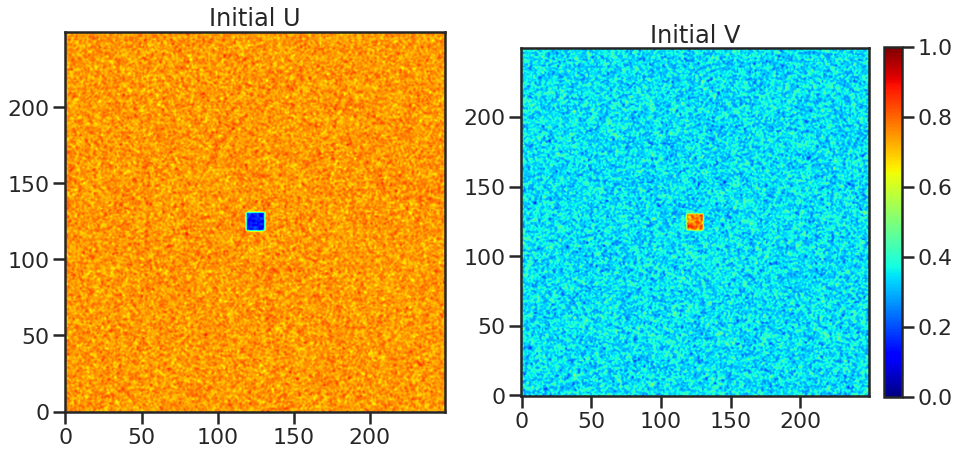

In [59]:
n=250
U, V = np.zeros((n, n), dtype=np.float64), np.zeros((n, n), dtype=np.float64)
r, m = n//40, n//2
U[...] = 1.0
V[m-r:m+r, m-r:m+r] = 0.25
U[m-r:m+r, m-r:m+r] = 0.5
U += np.random.normal(scale=0.05, size=U.shape)
V += np.random.normal(scale=0.05, size=V.shape)

U = U - np.min(U)
U = U / np.max(U)

V = V - np.min(V)
V = V / np.max(V)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.set_title("Initial U")
ax2.set_title("Initial V")
im1 = ax1.imshow(U, origin='lower', interpolation='bicubic', cmap='jet')
im2 = ax2.imshow(V, origin='lower', interpolation='bicubic', cmap='jet')
fig.colorbar(im1,fraction=0.046, pad=0.04)
plt.show()

In [23]:
s = [[1,1,1],
     [1,1,1],
     [1,1,1]]

@numba.njit(fastmath=True, parallel=True)
def gray_scott(U, V, Du, Dv, f, k, dt, dx, T):
    n = U.shape[0]
    iters = int(T / dt)
    for i in range(iters):
        Lu, Lv = Du*lap(U, n)/dx/dx, Dv*lap(V, n)/dx/dx
        U, V = U + dt*(Lu - U*V*V + f * (1-U)), V + dt*(Lv + U*V*V - (f+k) * V)
    return U, V

def gscott(n, F, k, T, Du=0.16, Dv=0.08, dt=1.0, dx=1.0, seed=5000000):
    np.random.seed(seed=seed) ## re-initialize seed to keep same initial conditions at each parameter setting
    U, V = np.zeros((n, n), dtype=np.float64), np.zeros((n, n), dtype=np.float64)
    r, m = n//40, n//2
    U[...] = 1.0
    V[m-r:m+r, m-r:m+r] = 0.25
    U[m-r:m+r, m-r:m+r] = 0.5
    U += np.random.normal(scale=0.05, size=U.shape)
    V += np.random.normal(scale=0.05, size=V.shape)
    return gray_scott(U, V, Du, Dv, F, k, dt, dx, T)

def calc_objects(inp):
    fftding = np.fft.fft2(inp)
    outp = ndimage.fourier_ellipsoid(fftding, 1.1)*100
    outp = np.fft.ifft2(ndimage.fourier_gaussian(outp, 1.01)).real*10

    binarized1 = np.clip(outp-((outp.min() + outp.max())/2), 0, 1)
    labels1 = ndimage.label(binarized1, structure=s)
    binarized2 = np.clip((outp-((outp.min() + outp.max())/2))*-1, 0, 1)
    labels2 = ndimage.label(binarized2, structure=s)
    if labels1[1] > labels2[1]:
        bins, edges = np.histogram(labels1[0], bins=labels1[1])
        return bins[1:]

    # Try inversed region
    if labels2[1] > 1:
        bins, edges = np.histogram(labels2[0], bins=labels2[1])
        return bins[1:]
    
    # No objects
    return np.zeros(1)

@numba.njit(parallel=True, fastmath=True)
def lap(u, N):
    uc = np.empty((N, N))
    for x in numba.prange(1, N-1):
        uc[x, 1:-1] = u[x+1, 1:-1] + u[x-1, 1:-1] + u[x, :-2] + u[x, 2:] - 4*u[x, 1:-1]

    uc[1:-1, 0] = u[1:-1, 1] + u[:-2, 0] + u[2:, 0] + u[1:-1, -1] - 4*u[1:-1, 0]
    uc[1:-1, -1] = u[1:-1, -2] + u[:-2, -1] + u[2:, -1] + u[1:-1, 0] - 4*u[1:-1, -1]
    uc[0, 1:-1] = u[1, 1:-1] + u[0, 2:] + u[0, :-2] + u[-1, 1:-1] - 4*u[0, 1:-1]
    uc[-1, 1:-1] = u[-2, 1:-1] + u[-1, 2:] + u[-1, :-2] + u[0, 1:-1] - 4*u[-1, 1:-1]

    uc[0, 0] = u[0, 1] + u[0, -1] + u[1, 0] + u[-1, 0] - 4*u[0, 0]
    uc[-1, 0] = u[0, 0] + u[-2, 0] + u[-1, -1] + u[-1, -2] - 4*u[-1, 0]
    uc[0, -1] = u[0, 0] + u[0, -2] + u[-1, -1] + u[1, -1] - 4*u[0, -1]
    uc[-1, -1] = u[0, -1] + u[-1, 0] + u[-1, -2] + u[-2, -1] - 4*u[-1, -1]
    return uc

In [32]:
def gaus_hack(inp):
    if len(np.unique(inp)) == 1:
        return lambda x: 0
    return gaussian_kde(inp)

def fim(x, ind, pdfs, df, dk):
    if np.all(ind): # (1, 1) index
        vals = np.array([pdfs[0](x), pdfs[1](x), pdfs[2](x)])
        if np.any(vals < 1e-8):
            return 0.0
        return vals[0] * (np.log(vals[1]) - np.log(vals[2]))**2 / (4.0 * dk * dk)
    elif np.any(ind): # (1, 0) or (0, 1) index
        vals = np.array([i(x) for i in pdfs])
        if np.any(vals < 1e-8):
            return 0.0
        return vals[0] * (np.log(vals[1]) - np.log(vals[2]))\
               * (np.log(vals[3]) - np.log(vals[4])) / (4.0 * df * dk)
    # (0, 0) index otherwise
    vals = np.array([pdfs[0](x), pdfs[3](x), pdfs[4](x)])
    if np.any(vals < 1e-8):
        return 0.0
    return vals[0] * (np.log(vals[1]) - np.log(vals[2]))**2 / (4.0 * df * df)
    
def fisher_matrix(inps, df, dk):
    p = [gaus_hack(i) for i in inps]
    FIM = np.zeros((2, 2))
    for i in np.ndindex(2, 2):
        FIM[i] = quad(fim, -np.inf, np.inf, args=(i, p, df, dk), limit=1000)[0]
    return FIM



def bulk_fisher(f, k, df, dk, n=150, T=10000):
    iters = len(f) * len(k)
    
    f, k = np.meshgrid(f, k)
    outp = np.zeros((*f.shape, 2, 2))
    for index, _f in tqdm(np.ndenumerate(f), total=iters):
        u, v = gscott(n, _f, k[index], T)
        u1,v1 = gscott(n, _f, k[index]+dk, T)
        u2,v2 = gscott(n, _f, k[index]-dk, T)
        u3,v3 = gscott(n, _f+df, k[index], T)
        u4,v4 = gscott(n, _f-df, k[index], T)
        
        inputs = [calc_objects(x) for x in [u, u1, u2, u3, u4]]
        outp[index] = fisher_matrix(inputs, df, dk)
    return outp

def bulk_fisher1d(f, k, df, dk, n=250, T=20000):
    iters = len(f)
    
    outp = np.zeros((len(f), 2, 2))
    for index, _f in tqdm(np.ndenumerate(f), total=iters):
        u, v = gscott(n, _f, k[index], T)
        u1,v1 = gscott(n, _f, k[index]+dk, T)
        u2,v2 = gscott(n, _f, k[index]-dk, T)
        u3,v3 = gscott(n, _f+df, k[index], T)
        u4,v4 = gscott(n, _f-df, k[index], T)
        
        inputs = [calc_objects(x) for x in [u, u1, u2, u3, u4]]
        outp[index] = fisher_matrix(inputs, df, dk)
    return outp

In [ ]:
ds2 = [x[0,1]*dtheta*dtheta for x in outp]

In [33]:
df = 0.0001
dk = 0.0001
f_min = 0.0238191
f_max = 0.0271360
k_min = 0.05869347
k_max = 0.06141
p1 = np.array([k_min, f_min])
p2 = np.array([k_max, f_max])
dr = (p2 - p1)/np.linalg.norm(p2 - p1)
dtheta = np.vdot([dk, df], dr)

f = np.linspace(0.0238191, 0.0271360, 250)
k = np.linspace(0.05869347, 0.06141, 250)
outp = bulk_fisher1d(f, k,dk,df)
print(outp)
ds2 = [x[0,1]*dtheta*dtheta for x in outp]


/home/coen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


[[[ 1.15831498e+07  3.94398085e+06]
  [ 3.94398085e+06  9.46696317e+06]]

 [[ 1.81619233e+06 -2.96953674e+06]
  [-2.96953674e+06  1.45251603e+07]]

 [[ 2.13431905e+06 -5.02457437e+05]
  [-5.02457437e+05  6.54652304e+06]]

 [[ 7.28346901e+06  6.88645150e+05]
  [ 6.88645150e+05  6.20301891e+06]]

 [[ 8.59337115e+06 -4.37905466e+06]
  [-4.37905466e+06  6.75649916e+06]]

 [[ 1.10100504e+07 -8.35265208e+05]
  [-8.35265208e+05  3.03701078e+06]]

 [[ 9.10985759e+06 -2.20192816e+06]
  [-2.20192816e+06  7.96792557e+06]]

 [[ 7.35235216e+06 -4.01416673e+05]
  [-4.01416673e+05  1.04667537e+06]]

 [[ 4.93248754e+07 -1.45277418e+07]
  [-1.45277418e+07  1.27537145e+07]]

 [[ 1.31955614e+06  3.76414438e+05]
  [ 3.76414438e+05  8.17321208e+06]]

 [[ 1.50313237e+07 -2.50734841e+06]
  [-2.50734841e+06  4.97533986e+06]]

 [[ 1.80054892e+07 -5.36883840e+06]
  [-5.36883840e+06  2.49421720e+07]]

 [[ 8.89056457e+06  2.71211907e+06]
  [ 2.71211907e+06  3.15268796e+06]]

 [[ 1.41141286e+07 -4.28214665e+06]
  

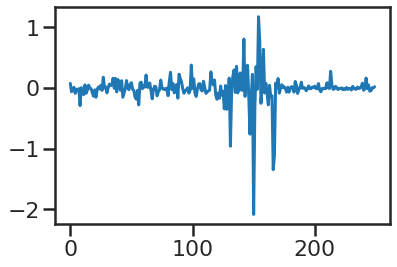

In [34]:
plt.plot(ds2)

In [35]:
np.savetxt("ds2", np.array(ds2))

In [ ]:
f

In [ ]:
for i, _f in np.ndenumerate(f):
    print(f"{i}  {_f}")

In [ ]:
f.shape[0]

In [ ]:
f[(1,)]

In [36]:
df = 0.0001
dk = 0.0001

k = np.linspace(0.0652, 0.0632, 250)
f = np.linspace(0.0395, 0.04228, 250)

f1 = 0.0238191
f2 = 0.0271360
k1 = 0.05869347
k2 = 0.06141
p1 = np.array([k1, f1])
p2 = np.array([k2, f2])
dr = (p2 - p1)/np.linalg.norm(p2 - p1)
dtheta = np.vdot([dk, df], dr)

outp2 = bulk_fisher1d(f, k,dk,df)
ds2v2 = [x[0,1]*dtheta*dtheta for x in outp2]
np.savetxt("ds2v2", np.array(ds2v2))

/home/coen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


In [40]:
f1 = 0.0395
f2 = 0.04228
k1 = 0.0652
k2 = 0.0632
p1 = np.array([k1, f1])
p2 = np.array([k2, f2])
dr = (p2 - p1)/np.linalg.norm(p2 - p1)
dtheta = np.vdot([dk, df], dr)
ds2v2 = np.abs([x[0,1]*dtheta*dtheta for x in outp2])
np.savetxt("ds2v2", np.array(ds2v2))

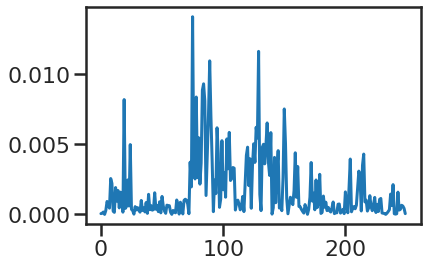

In [41]:
plt.plot(ds2v2)